<h1 style="color: #FF5733;">Data Visualization</h1>

<h1 style="color: #FF5733;">Peak Hour Identification & Pattern Analysis</h1>

In [1]:
import pandas as pd 
df= pd.read_csv("C:\\Users\\PC\\Desktop\\merged_data.csv")

<mark>***Calculate congestion metrics*** </mark>

=== Peak Traffic Hours by Junction ===
    Junction  Hour  AvgVehicles
19         1    19    58.804276
68         3    20    20.200658
44         2    20    18.060855
84         4    12    10.237569


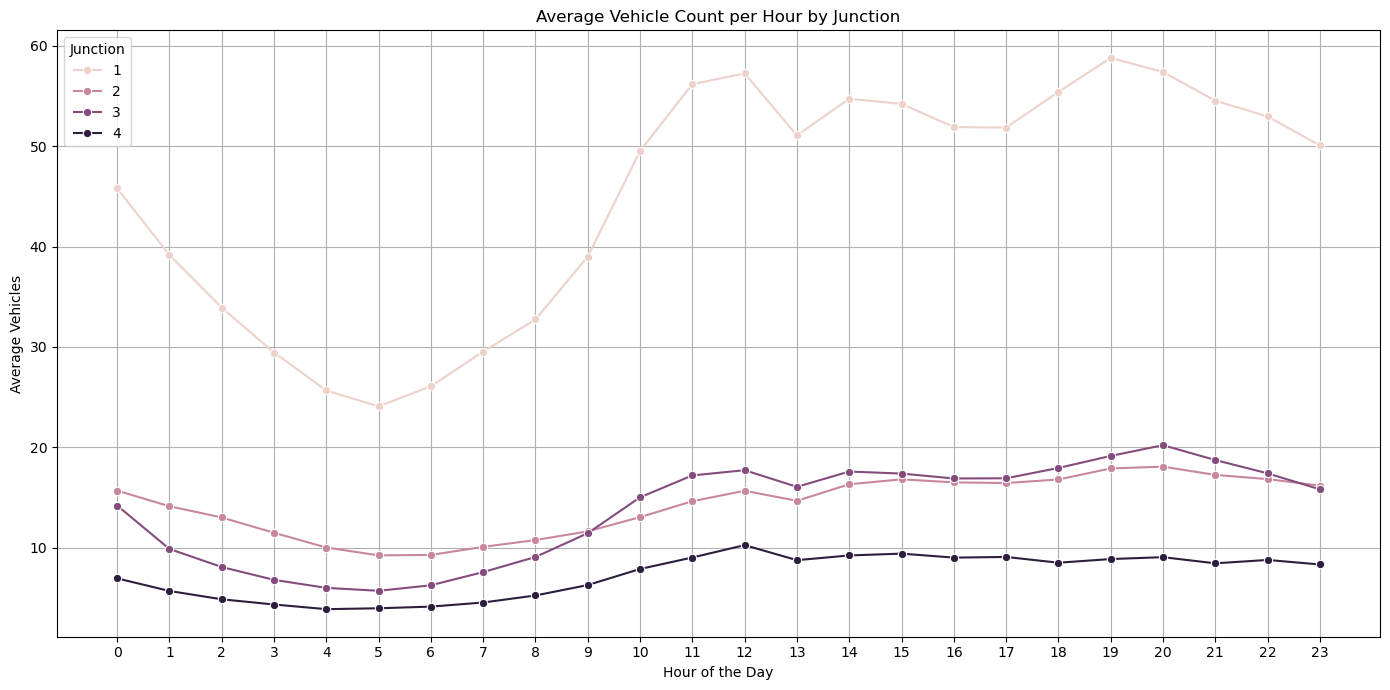

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure datetime is in the right format
df['FinalDateTime'] = pd.to_datetime(df['FinalDateTime'])

# Extract hour
df['Hour'] = df['FinalDateTime'].dt.hour

# Average vehicles per hour per junction
hourly_congestion = df.groupby(['Junction', 'Hour'])['Vehicles'].mean().reset_index()
hourly_congestion.rename(columns={'Vehicles': 'AvgVehicles'}, inplace=True)

# Find peak hour per junction
peak_hours = hourly_congestion.loc[hourly_congestion.groupby('Junction')['AvgVehicles'].idxmax()]
peak_hours = peak_hours.sort_values(by='AvgVehicles', ascending=False)

print("=== Peak Traffic Hours by Junction ===")
print(peak_hours)

# Plot it
plt.figure(figsize=(14, 7))
sns.lineplot(data=hourly_congestion, x='Hour', y='AvgVehicles', hue='Junction', marker="o")
plt.title("Average Vehicle Count per Hour by Junction")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Vehicles")
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


<mark>***Identify peak hours***</mark>

C:\Users\PC\AppData\Local\Temp\ipykernel_7224\2870353816.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_stats = hourly_stats.groupby('Junction').apply(mark_peaks)


=== Statistically Identified Peak Hours ===
             Junction  Hour  AvgVehicles
Junction                                
1        19         1    19    58.804276
         20         1    20    57.401316
         12         1    12    57.254934
3        68         3    20    20.200658
         67         3    19    19.129934
         69         3    21    18.722039
2        44         2    20    18.060855
         43         2    19    17.883224
         45         2    21    17.236842
4        84         4    12    10.237569
         87         4    15     9.392265


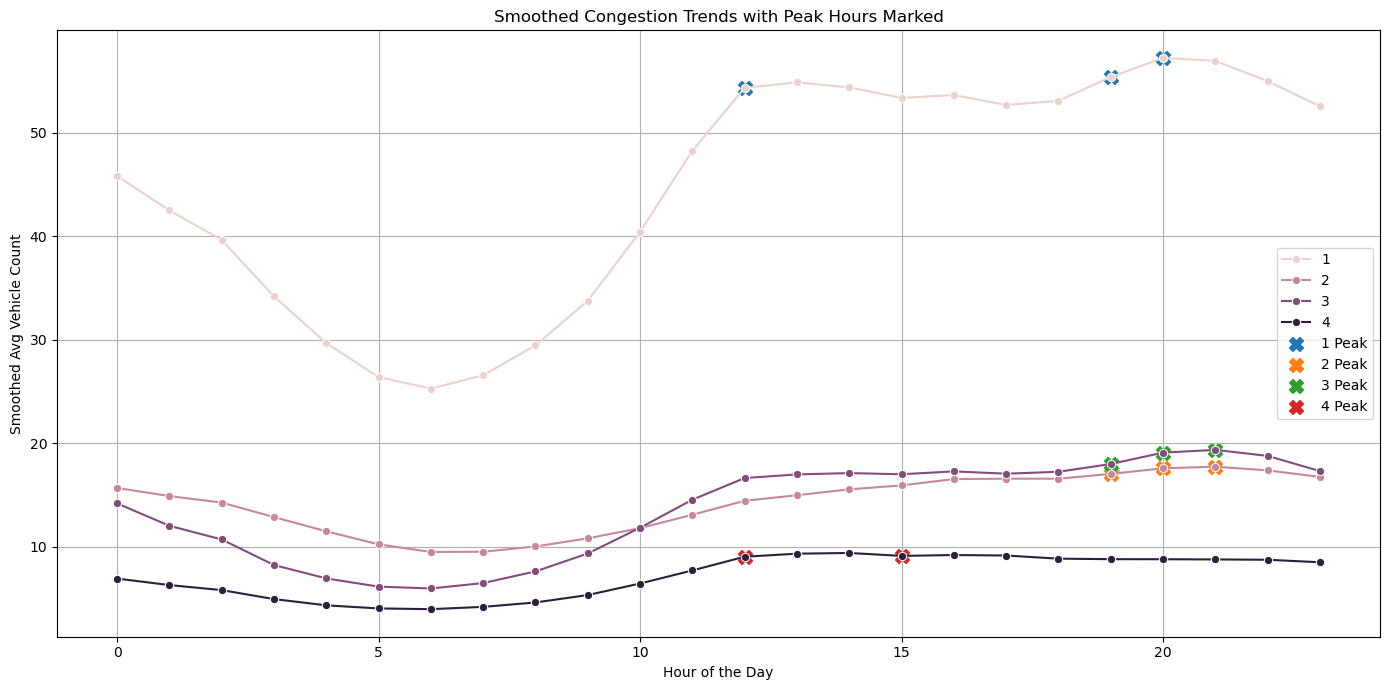

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming merged_df has columns: FinalDateTime, Junction, Vehicles
df['FinalDateTime'] = pd.to_datetime(df['FinalDateTime'])
df['Hour'] = df['FinalDateTime'].dt.hour

# Step 1: Calculate average vehicle count by Hour and Junction
hourly_stats = df.groupby(['Junction', 'Hour'])['Vehicles'].mean().reset_index()
hourly_stats.rename(columns={'Vehicles': 'AvgVehicles'}, inplace=True)

# Step 2: Apply a moving average (3-hour window smoothing)
hourly_stats['MovingAvg'] = hourly_stats.groupby('Junction')['AvgVehicles'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Step 3: Identify peak hours (above 1 standard deviation from mean for each Junction)
def mark_peaks(group):
    mean = group['AvgVehicles'].mean()
    std = group['AvgVehicles'].std()
    group['IsPeak'] = group['AvgVehicles'] > (mean + std)
    return group

hourly_stats = hourly_stats.groupby('Junction').apply(mark_peaks)

# Print identified peak hours
peak_hours = hourly_stats[hourly_stats['IsPeak']]
print("=== Statistically Identified Peak Hours ===")
print(peak_hours[['Junction', 'Hour', 'AvgVehicles']].sort_values(by='AvgVehicles', ascending=False))

# Step 4: Visualization
plt.figure(figsize=(14, 7))
sns.lineplot(data=hourly_stats, x='Hour', y='MovingAvg', hue='Junction', marker='o')
for junction in hourly_stats['Junction'].unique():
    peaks = hourly_stats[(hourly_stats['Junction'] == junction) & (hourly_stats['IsPeak'])]
    plt.scatter(peaks['Hour'], peaks['MovingAvg'], label=f"{junction} Peak", s=100, marker='X')

plt.title('Smoothed Congestion Trends with Peak Hours Marked')
plt.xlabel('Hour of the Day')
plt.ylabel('Smoothed Avg Vehicle Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<mark>***Examine temporal patterns***</mark>

***patterns by day of the week to determine if peak hours vary between weekdays and weekends.***

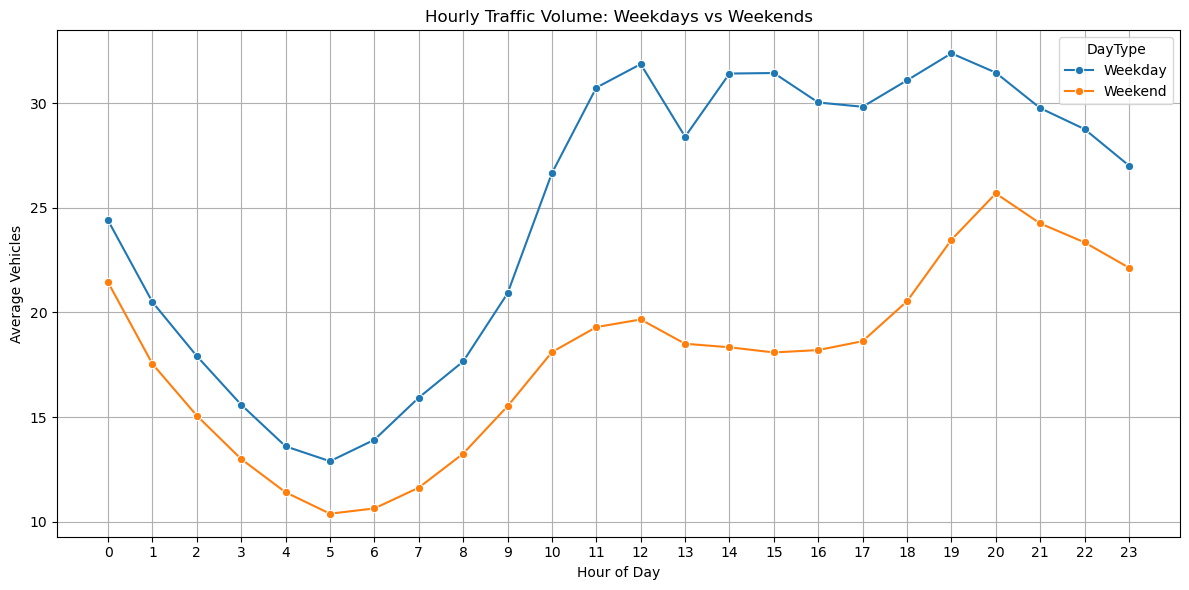

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume FinalDateTime is already parsed
df['DayOfWeek'] = df['FinalDateTime'].dt.dayofweek  # 0 = Monday, 6 = Sunday
df['Month'] = df['FinalDateTime'].dt.month
df['IsWeekend'] = df['DayOfWeek'] >= 5

# === 1. Weekly Pattern Analysis ===
# Average vehicles by Hour & Weekend status
week_pattern = df.groupby(['IsWeekend', 'Hour'])['Vehicles'].mean().reset_index()
week_pattern['DayType'] = week_pattern['IsWeekend'].map({True: 'Weekend', False: 'Weekday'})

# Plot hourly traffic for Weekdays vs Weekends
plt.figure(figsize=(12, 6))
sns.lineplot(data=week_pattern, x='Hour', y='Vehicles', hue='DayType', marker='o')
plt.title('Hourly Traffic Volume: Weekdays vs Weekends')
plt.xlabel('Hour of Day')
plt.ylabel('Average Vehicles')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

# === 2. Monthly Pattern Analysis ===
monthly_pattern = df.groupby(['Month', 'Hour'])['Vehicles'].mean().reset_index()





 ***monthly or seasonal variations in peak hours***

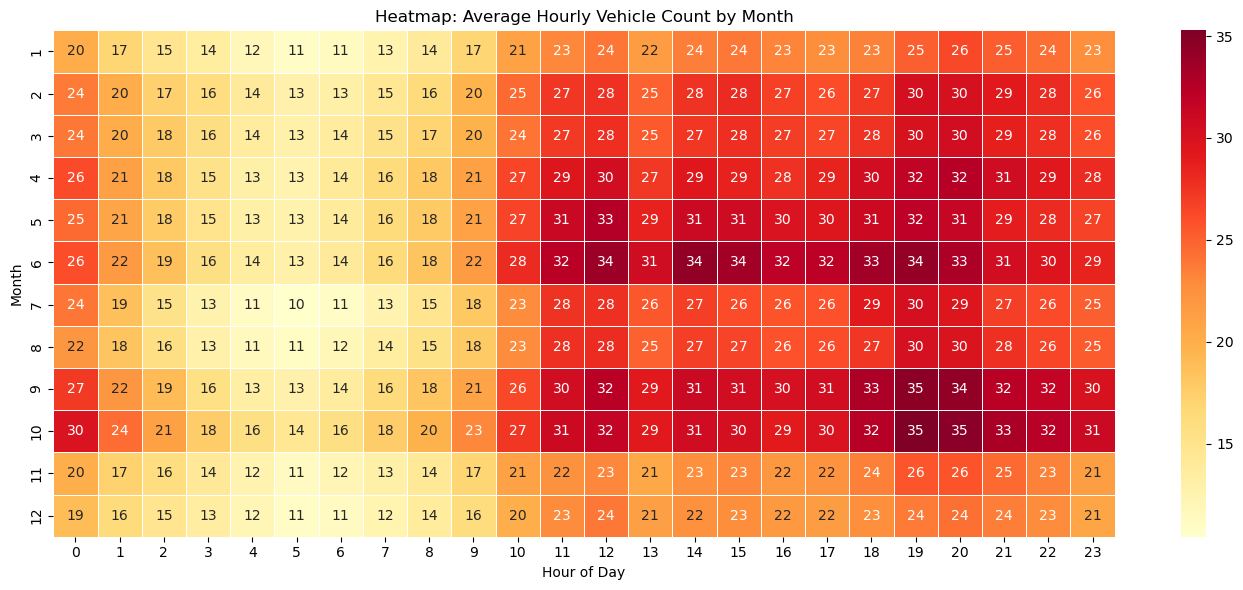

In [22]:
# Grouping average vehicles by Month and Hour
monthly_pattern = df.groupby(['Month', 'Hour'])['Vehicles'].mean().reset_index()

# Corrected pivot usage
pivot_monthly = monthly_pattern.pivot(index='Month', columns='Hour', values='Vehicles')

# Plotting heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_monthly, cmap='YlOrRd', annot=True, fmt=".0f", linewidths=0.5)
plt.title('Heatmap: Average Hourly Vehicle Count by Month')
plt.xlabel('Hour of Day')
plt.ylabel('Month')
plt.tight_layout()
plt.show()


<mark>***Analyze influencing factors.***</mark>

***Correlate Weather with Peak Traffic***

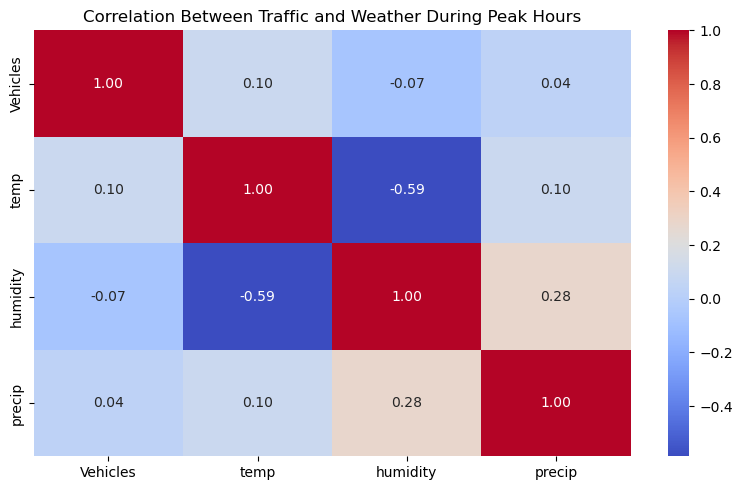

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Let's assume merged_df already has weather columns like:
# 'temp', 'humidity', 'precip', 'preciptype' and traffic data

# First: Filter only PEAK HOURS based on prior analysis (e.g., 8-10 AM and 5-7 PM)
peak_df = df[(df['Hour'].isin([7, 8, 9, 17, 18, 19]))]

# Drop rows with missing values in weather columns (if any)
peak_df = peak_df.dropna(subset=['temp', 'humidity', 'precip', 'Vehicles'])

# === Correlation Matrix: Traffic vs Weather ===
corr_matrix = peak_df[['Vehicles', 'temp', 'humidity', 'precip']].corr()

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Traffic and Weather During Peak Hours')
plt.tight_layout()
plt.show()


***Analyze Impact of Rain or Events***

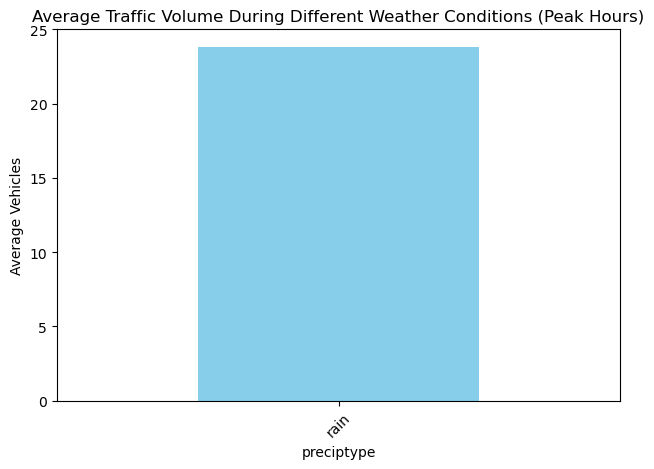

In [39]:
# Group by weather type if available (like 'rain', 'snow', etc.)
if 'preciptype' in peak_df.columns:
    weather_group = peak_df.groupby('preciptype')['Vehicles'].mean().sort_values(ascending=False)
    weather_group.plot(kind='bar', color='skyblue')
    plt.title('Average Traffic Volume During Different Weather Conditions (Peak Hours)')
    plt.ylabel('Average Vehicles')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


<mark>***Correlation Analysis***</mark>

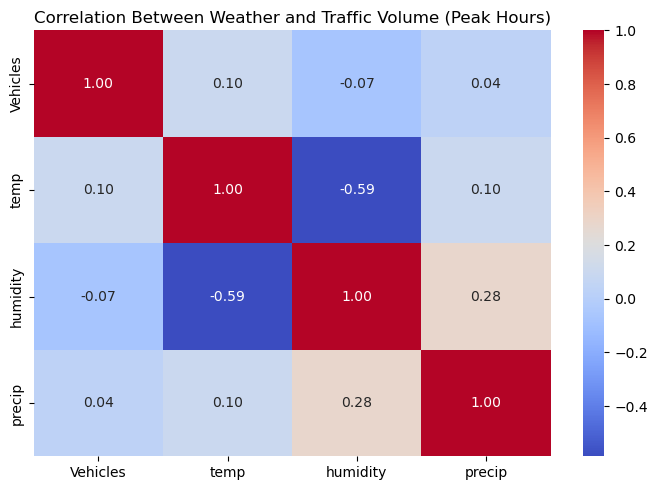

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for peak hours
peak_df = df[df['Hour'].isin([7, 8, 9, 17, 18, 19])]

# Ensure weather + traffic columns are clean
corr_cols = ['Vehicles', 'temp', 'humidity', 'precip']
peak_corr_df = peak_df[corr_cols].dropna()

# Correlation matrix
corr_matrix = peak_corr_df.corr()

# Heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Weather and Traffic Volume (Peak Hours)')
plt.tight_layout()
plt.show()


<h1 style="color: #FF5733;">Visualisation and Reporting</h1>


<mark>***Visualizations***</mark>


***Hourly Traffic Across Days of the Week***

C:\Users\PC\AppData\Local\Temp\ipykernel_7224\3753524321.py:16: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout()
C:\Users\PC\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


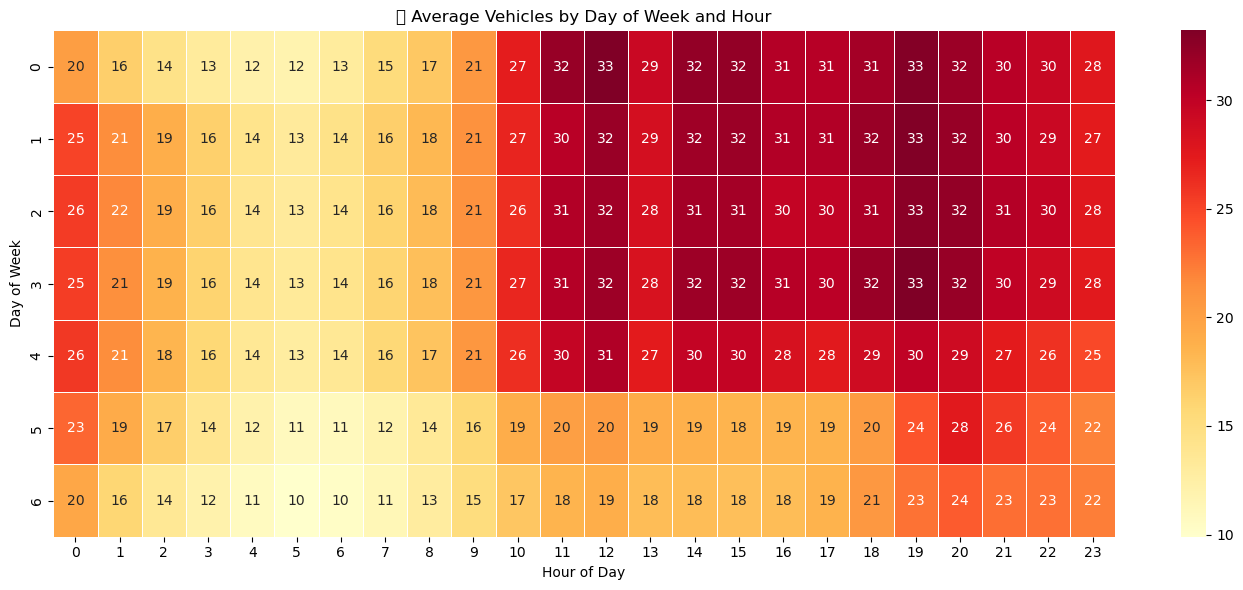

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Average vehicles by day and hour
heatmap_df = df.groupby(['DayOfWeek', 'Hour'])['Vehicles'].mean().reset_index()

# Pivot for heatmap
pivot_day_hour = heatmap_df.pivot(index='DayOfWeek', columns='Hour', values='Vehicles')

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_day_hour, cmap='YlOrRd', annot=True, fmt=".0f", linewidths=0.5)
plt.title('🔄 Average Vehicles by Day of Week and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()


***Hourly Traffic Across Months***

C:\Users\PC\AppData\Local\Temp\ipykernel_7224\952654641.py:13: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from current font.
  plt.tight_layout()
C:\Users\PC\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


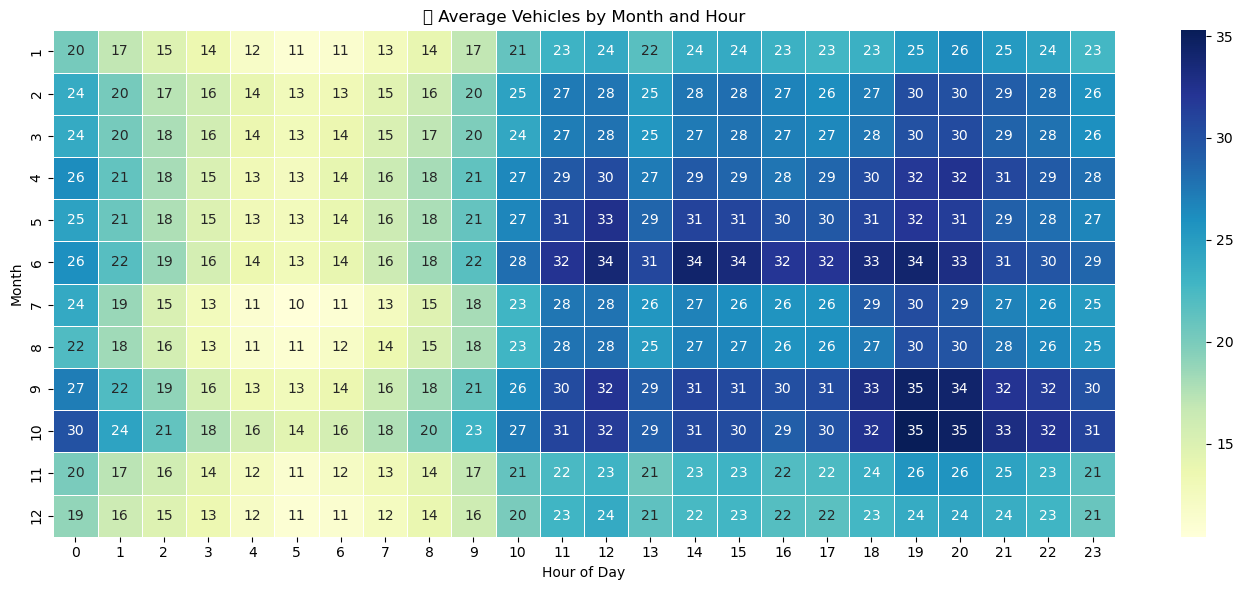

In [57]:
# Group by Month and Hour
monthly_pattern = df.groupby(['Month', 'Hour'])['Vehicles'].mean().reset_index()

# Pivot for heatmap
pivot_month_hour = monthly_pattern.pivot(index='Month', columns='Hour', values='Vehicles')

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_month_hour, cmap='YlGnBu', annot=True, fmt=".0f", linewidths=0.5)
plt.title('📅 Average Vehicles by Month and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Month')
plt.tight_layout()
plt.show()


***Hourly Trend by Day Type (Weekday vs Weekend)***



C:\Users\PC\AppData\Local\Temp\ipykernel_7224\3448142577.py:9: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(data=weekend_trend, x='Hour', y='Vehicles', hue='IsWeekend', palette=['blue', 'orange'])
C:\Users\PC\AppData\Local\Temp\ipykernel_7224\3448142577.py:15: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\PC\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


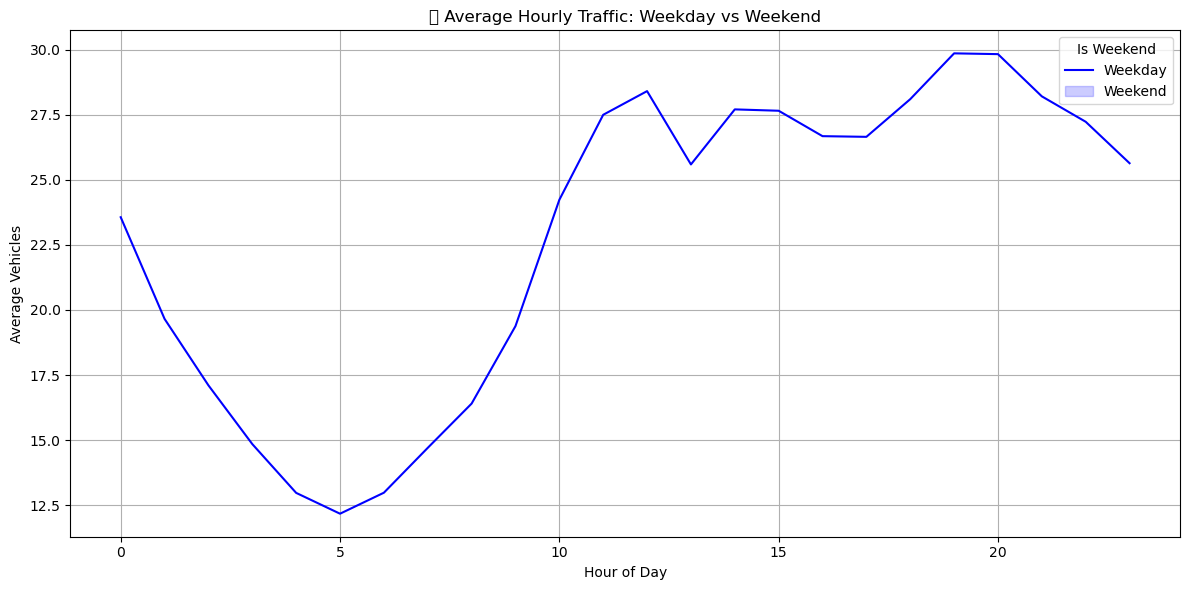

In [60]:
# Add column: IsWeekend
df['IsWeekend'] = df['DayOfWeek'].isin(['Saturday', 'Sunday'])

# Group by weekend and hour
weekend_trend = df.groupby(['IsWeekend', 'Hour'])['Vehicles'].mean().reset_index()

# Plot line
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekend_trend, x='Hour', y='Vehicles', hue='IsWeekend', palette=['blue', 'orange'])
plt.title('📊 Average Hourly Traffic: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Average Vehicles')
plt.legend(title='Is Weekend', labels=['Weekday', 'Weekend'])
plt.grid(True)
plt.tight_layout()
plt.show()


***Average Daily Traffic by Day of Week***



C:\Users\PC\AppData\Local\Temp\ipykernel_7224\2289995924.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=daily_avg.index, y=daily_avg.values, palette='viridis')
C:\Users\PC\AppData\Local\Temp\ipykernel_7224\2289995924.py:10: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\PC\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


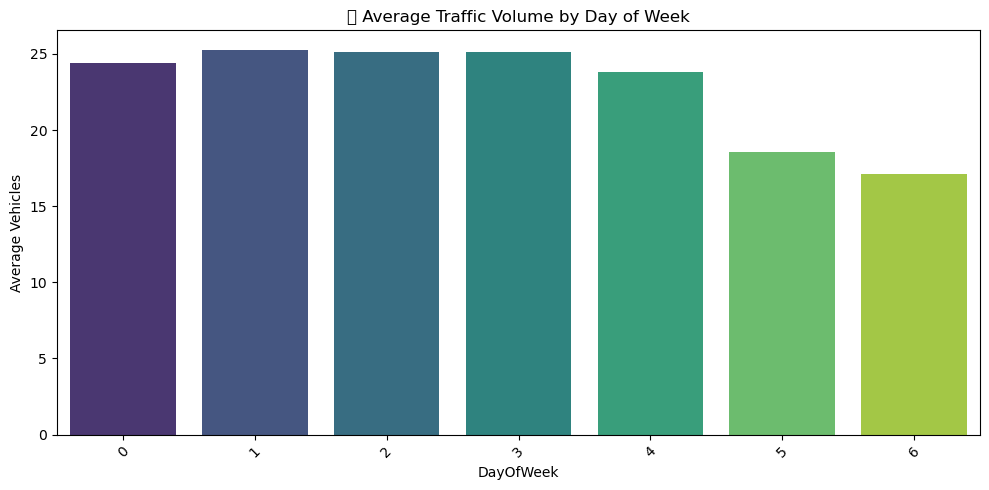

In [63]:
# Group by day of week
daily_avg = df.groupby('DayOfWeek')['Vehicles'].mean().sort_values()

# Bar plot
plt.figure(figsize=(10, 5))
sns.barplot(x=daily_avg.index, y=daily_avg.values, palette='viridis')
plt.title('📈 Average Traffic Volume by Day of Week')
plt.ylabel('Average Vehicles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<mark>***Visualizing the Impact of External Factors on Peak Traffic Hours***</mark>

***Temperature vs. Traffic Volume***

C:\Users\PC\AppData\Local\Temp\ipykernel_7224\3639878218.py:7: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  plt.tight_layout()
C:\Users\PC\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


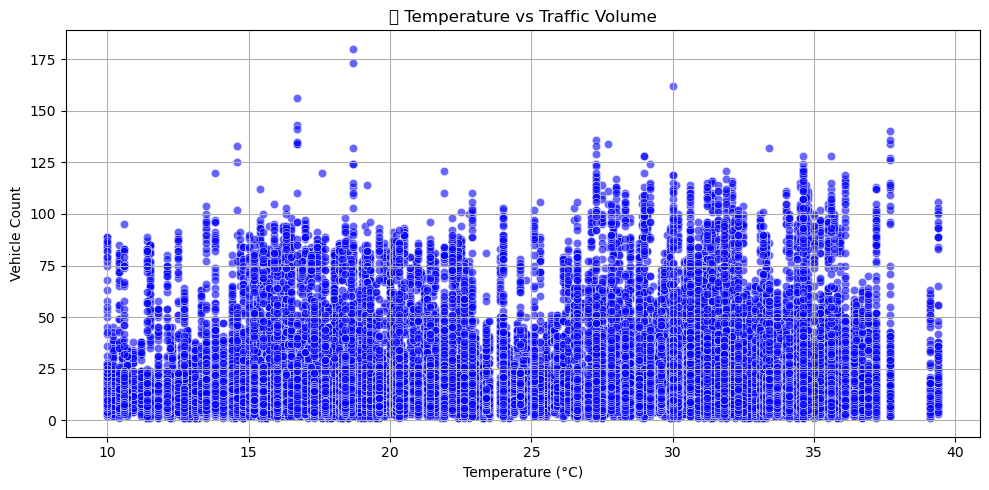

In [69]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='temp', y='Vehicles', alpha=0.6, color='blue')
plt.title('🌡️ Temperature vs Traffic Volume')
plt.xlabel('Temperature (°C)')
plt.ylabel('Vehicle Count')
plt.grid(True)
plt.tight_layout()
plt.show()


***Rainfall Impact on Peak Traffic***

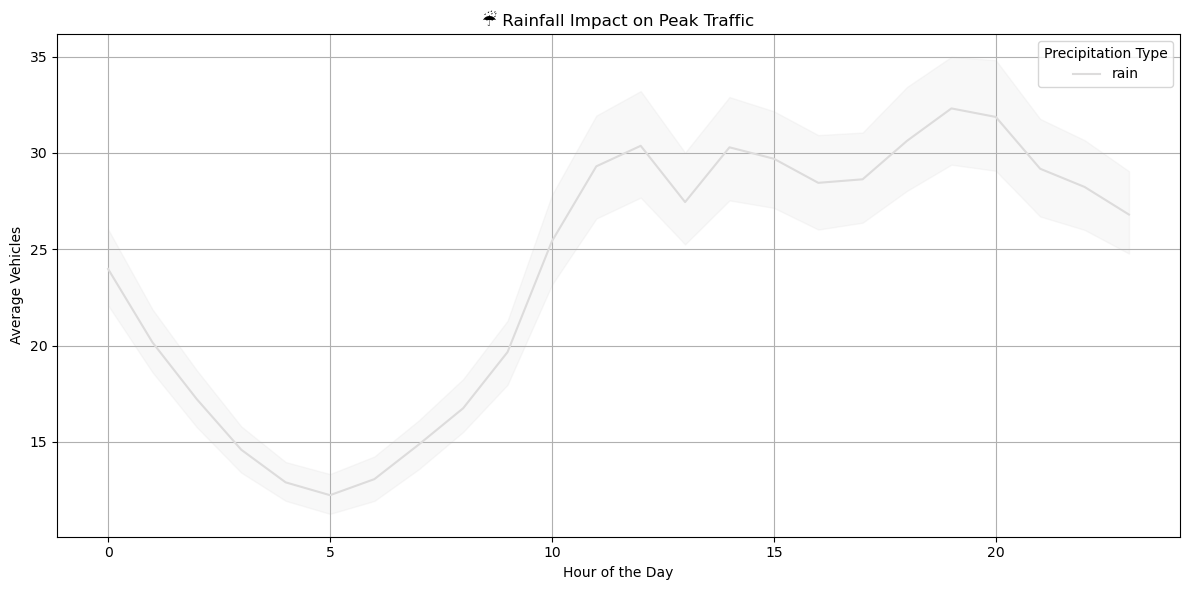

In [72]:
plt.figure(figsize=(12, 6))
sns.lineplot(data= df, x='Hour', y='Vehicles', hue='preciptype', palette='coolwarm')
plt.title('☔ Rainfall Impact on Peak Traffic')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Vehicles')
plt.legend(title='Precipitation Type')
plt.grid(True)
plt.tight_layout()
plt.show()


***Impact of Weather on Traffic Volume***

C:\Users\PC\AppData\Local\Temp\ipykernel_7224\817503003.py:6: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  plt.tight_layout()
C:\Users\PC\AppData\Local\Temp\ipykernel_7224\817503003.py:6: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
C:\Users\PC\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\PC\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


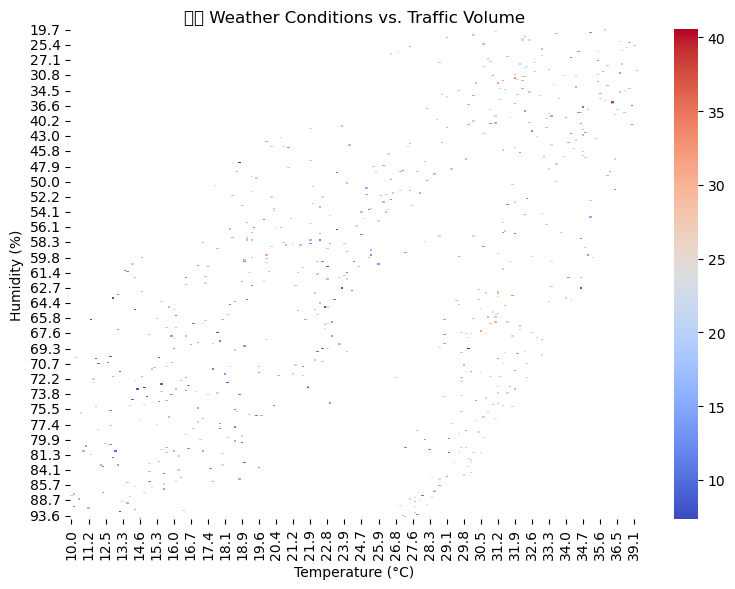

In [78]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.pivot_table(values='Vehicles', index='humidity', columns='temp'), cmap='coolwarm', annot=False)
plt.title('🌡️🔥 Weather Conditions vs. Traffic Volume')
plt.xlabel('Temperature (°C)')
plt.ylabel('Humidity (%)')
plt.tight_layout()
plt.show()
